# From Square-Root Law to Dynamic Trade Effects

## 1. The dataset

From binance cryptocurrency api via the binance-LOB repository (https://github.com/pfei-sa/binance-LOB/tree/main)

Quotes data with a depth of 100 into the LOB timestamp, ask price, ask volume, bid price, bid volume, midpoint, spread

Trades data withtimestamp, price, volume, trade sign (-1 = sell, 1 = buy)

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [10]:
trades_df = pd.concat([
    pd.read_csv(file, header=None, names=[
        'trade_id', 'price', 'volume', 'quote_volume', 
        'timestamp', 'is_buyer_maker', 'is_best_match'
    ]) for file in glob.glob(os.path.join("data/binance_raw", "BTCUSDT-trades*.csv"))
], ignore_index=True)

trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'], unit='ns')
trades_df['price'] = trades_df['price'].astype(float)
trades_df['volume'] = trades_df['volume'].astype(float)
trades_df['trade_sign'] = trades_df['is_buyer_maker'].apply(lambda x: -1 if x else 1)
trades_df = trades_df.drop(columns=['is_buyer_maker', 'is_best_match'], axis=1)

volumes = trades_df['volume']
print(f"     Median: {np.median(volumes):.6f} BTC")
print(f"     Zero volumes: {np.sum(volumes == 0)} ({100*np.mean(volumes == 0):.2f}%)")
median_volume = np.median(volumes[volumes > 0])
scale_factor = 1.0 / median_volume
trades_clean = trades_df.copy()
trades_clean['volume_normalized'] = trades_clean['volume'] * scale_factor
print("   Scale factor:", scale_factor)
trades_clean['log_volume'] = np.log(trades_clean['volume_normalized'])
trades_clean['sqrt_volume'] = np.sqrt(trades_clean['volume_normalized'])

print(trades_clean.head())
print(trades_clean.shape)

ohlvc_df = pd.concat([
    pd.read_csv(file, header=None, names=[
                'open_time', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'count', 'taker_buy_volume',
                'taker_buy_quote_volume', 'ignore'
    ]) for file in glob.glob(os.path.join("data/binance_raw", "BTCUSDT-1s*.csv"))
], ignore_index=True)

ohlvc_df['open_time'] = pd.to_datetime(ohlvc_df['open_time'], unit='ns')
ohlvc_df['close_time'] = pd.to_datetime(ohlvc_df['close_time'], unit='ns')
ohlvc_df['midpoint'] = (ohlvc_df['high'] + ohlvc_df['low'])/2
ohlvc_df['spread'] = 2 * (ohlvc_df['high'] - ohlvc_df['low'])

prices = trades_clean['price'].values
signs = trades_clean['trade_sign'].values
volumes = trades_clean['volume_normalized'].values
log_volumes = trades_clean['log_volume'].values

     Median: 0.000050 BTC
     Zero volumes: 0 (0.00%)
   Scale factor: 20000.0
     trade_id      price   volume  quote_volume                     timestamp  \
0  5129304097  112546.35  0.00018     20.258343 1970-01-21 07:16:19.200039304   
1  5129304098  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   
2  5129304099  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   
3  5129304100  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   
4  5129304101  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   

   trade_sign  volume_normalized  log_volume  sqrt_volume  
0           1                3.6    1.280934     1.897367  
1           1                1.0    0.000000     1.000000  
2           1                1.0    0.000000     1.000000  
3           1                1.0    0.000000     1.000000  
4           1                1.0    0.000000     1.000000  
(7408539, 9)


## 1. Baseline Implementation
- Square-Root Law: ΔP = Y σ√(Q/V)
- Parameter estimation and statistical validation
- Identify systematic deviations and failure modes

R(ℓ) measures how much, on average, the price moves up conditioned to a buy
order at time 0 (or a sell order moves the price down) a time ℓ later.

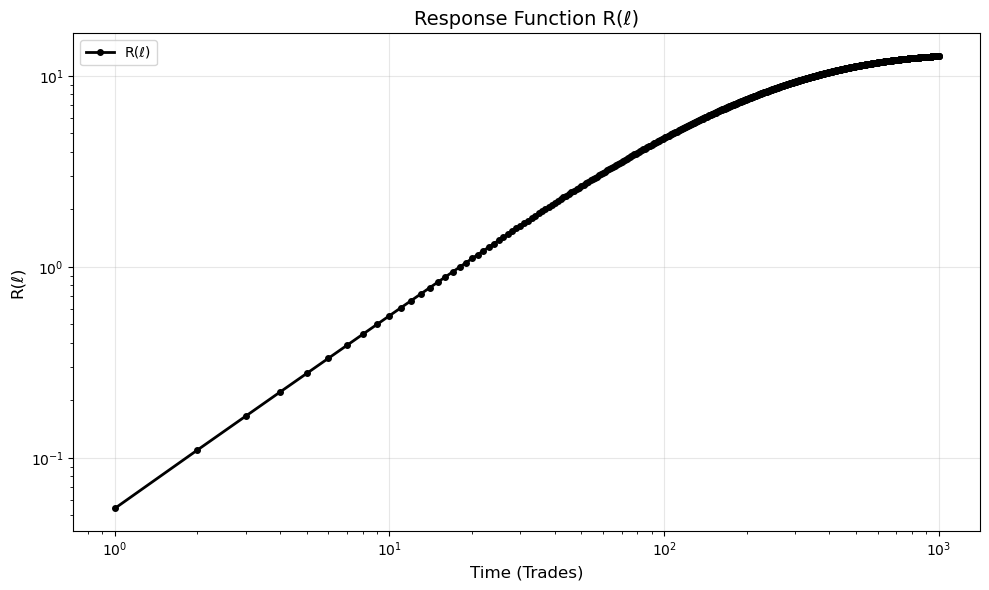

In [11]:
max_lag = 1000

def response(prices, signs, max_lag):

    n_trades = len(prices)
    lags = np.arange(1, min(max_lag + 1, n_trades // 2))
    response = np.zeros(len(lags))

    for i, lag in enumerate(lags):
        price_diffs = prices[lag:] - prices[:-lag]
        trade_signs = signs[:-lag]
        
        response[i] = np.mean(price_diffs * trade_signs)
    
    return lags, response

lags, response_func = response(prices, signs, max_lag)

plt.figure(figsize=(10, 6))
plt.loglog(lags, response_func, 'ko-', linewidth=2, markersize=4, label='R(ℓ)')
plt.xlabel('Time (Trades)', fontsize=12)
plt.ylabel('R(ℓ)', fontsize=12)
plt.title('Response Function R(ℓ)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

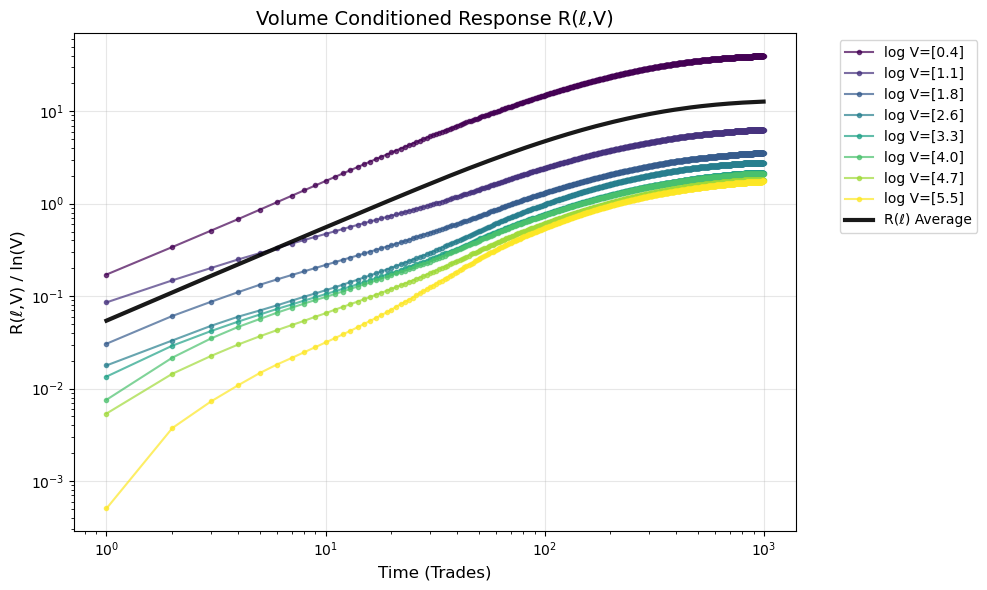

In [ ]:
def conditioned_response(prices, signs, volumes, log_vols, lags, n_vol_bins, vol_percentiles):

    n_trades = len(prices)

    # Log-spaced volume bins
    vol_min, vol_max = np.percentile(log_vols, vol_percentiles)
    vol_bins = np.logspace(vol_min, vol_max, n_vol_bins + 1, base=np.e)

    response_matrix = np.full((len(lags), n_vol_bins), np.nan)
    vol_centers = np.zeros(n_vol_bins)    

    for vol_idx in range(n_vol_bins):
        # Find trades in this volume bin
        vol_mask = (volumes >= vol_bins[vol_idx]) & (volumes < vol_bins[vol_idx + 1])
        vol_centers[vol_idx] = np.sqrt(vol_bins[vol_idx] * vol_bins[vol_idx + 1])
        
        if np.sum(vol_mask) < 50:  # Skip bins with few trades
            continue
        
        vol_indices = np.where(vol_mask)[0]
        
        for i, lag in enumerate(lags):
            valid_indices = vol_indices[vol_indices < n_trades - lag]
            
            if len(valid_indices) < 10:
                continue
                
            # response
            price_diffs = prices[valid_indices + lag] - prices[valid_indices]
            trade_signs = signs[valid_indices]
            response_matrix[i, vol_idx] = np.mean(price_diffs * trade_signs)

    return {
        'lags': lags,
        'vol_centers': vol_centers,
        'vol_bins': vol_bins,
        'response_matrix': response_matrix,
        'log_vol_centers': np.log(vol_centers)
    }

vol_data = conditioned_response(prices, signs, volumes, log_volumes, lags, n_vol_bins=8, vol_percentiles=(5, 95))

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(vol_data['vol_centers'])))

for vol_idx, (vol_center, color) in enumerate(zip(vol_data['vol_centers'], colors)):
    response_vol = vol_data['response_matrix'][:, vol_idx]
    valid_mask = ~np.isnan(response_vol)
    
    if np.sum(valid_mask) > 10:
        log_vol = np.log(vol_center)
        label = f'log V=[{log_vol:.1f}]'
        
        scaled_response = response_vol / np.log(vol_center)
        
        plt.loglog(lags[valid_mask], scaled_response[valid_mask], 
                    'o-', color=color, linewidth=1.5, markersize=3,
                    alpha=0.7, label=label) 

plt.loglog(lags, response_func, 'k-', linewidth=3, label='R(ℓ) Average', alpha=0.9)

plt.xlabel('Time (Trades)', fontsize=12)
plt.ylabel('R(ℓ,V) / ln(V)', fontsize=12)
plt.title('Volume Conditioned Response R(ℓ,V)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()


In [13]:
def sign_correlation(signs, log_vols, lags):

    mean_log_vol = np.mean(log_vols)
    mean_sign = np.mean(signs)
    mean_sign_squared = mean_sign**2

    C0 = np.zeros(len(lags))  # Basic sign correlation
    C1 = np.zeros(len(lags))  # Cross correlation with volume
    C2 = np.zeros(len(lags))  # Volume-weighted correlation

    for i, lag in enumerate(lags):
        print(f"  Lag {lag}/{max_lag}")
            
        idx_present = slice(None, -lag)  # [0, 1, ..., n-lag-1]  
        idx_future = slice(lag, None)    # [lag, lag+1, ..., n-1]
        
        signs_present = signs[idx_present]
        signs_future = signs[idx_future] 
        log_vols_present = log_vols[idx_present]
        log_vols_future = log_vols[idx_future]
        
        # C0(l) = <ε_{n+l} ε_n> - <ε_n>²
        C0[i] = np.mean(signs_future * signs_present) - mean_sign_squared
        
        # C1(l) = <ε_{n+l} ε_n ln V_n>
        C1[i] = np.mean(signs_future * signs_present * log_vols_present)
        
        # C2(l) = <ε_{n+l} ln V_{n+l} ε_n ln V_n>
        C2[i] = np.mean(signs_future * log_vols_future * signs_present * log_vols_present)

    return {
        'lags': lags,
        'C0': C0,
        'C1': C1, 
        'C2': C2,
        'mean_log_vol': mean_log_vol
    }

correlations = sign_correlation(signs, log_volumes, lags)

  Lag 1/1000
  Lag 2/1000
  Lag 3/1000
  Lag 4/1000
  Lag 5/1000
  Lag 6/1000
  Lag 7/1000
  Lag 8/1000
  Lag 9/1000
  Lag 10/1000
  Lag 11/1000
  Lag 12/1000
  Lag 13/1000
  Lag 14/1000
  Lag 15/1000
  Lag 16/1000
  Lag 17/1000
  Lag 18/1000
  Lag 19/1000
  Lag 20/1000
  Lag 21/1000
  Lag 22/1000
  Lag 23/1000
  Lag 24/1000
  Lag 25/1000
  Lag 26/1000
  Lag 27/1000
  Lag 28/1000
  Lag 29/1000
  Lag 30/1000
  Lag 31/1000
  Lag 32/1000
  Lag 33/1000
  Lag 34/1000
  Lag 35/1000
  Lag 36/1000
  Lag 37/1000
  Lag 38/1000
  Lag 39/1000
  Lag 40/1000
  Lag 41/1000
  Lag 42/1000
  Lag 43/1000
  Lag 44/1000
  Lag 45/1000
  Lag 46/1000
  Lag 47/1000
  Lag 48/1000
  Lag 49/1000
  Lag 50/1000
  Lag 51/1000
  Lag 52/1000
  Lag 53/1000
  Lag 54/1000
  Lag 55/1000
  Lag 56/1000
  Lag 57/1000
  Lag 58/1000
  Lag 59/1000
  Lag 60/1000
  Lag 61/1000
  Lag 62/1000
  Lag 63/1000
  Lag 64/1000
  Lag 65/1000
  Lag 66/1000
  Lag 67/1000
  Lag 68/1000
  Lag 69/1000
  Lag 70/1000
  Lag 71/1000
  Lag 72/1000
 

In [14]:
def power_law(x: np.ndarray, A: float, gamma: float) -> np.ndarray:
    return A * np.power(x, -gamma)

In [15]:
min_lag = 10

mask = (correlations['lags'] >= min_lag) & (correlations['lags'] <= max_lag) & (correlations['C0'] > 0)

# Linear fit: log(y) = log(A) - gamma * log(x)
if np.sum(mask) > 5:
    log_lags = np.log(lags[mask])
    log_corr = np.log(correlations['C0'][mask])
    
    coeffs = np.polyfit(log_lags, log_corr, 1)
    gamma = -coeffs[0]
    A = np.exp(coeffs[1])
    
    print(f"Ajustement C₀(ℓ) ∝ ℓ^(-{gamma:.3f})")

Ajustement C₀(ℓ) ∝ ℓ^(-0.803)


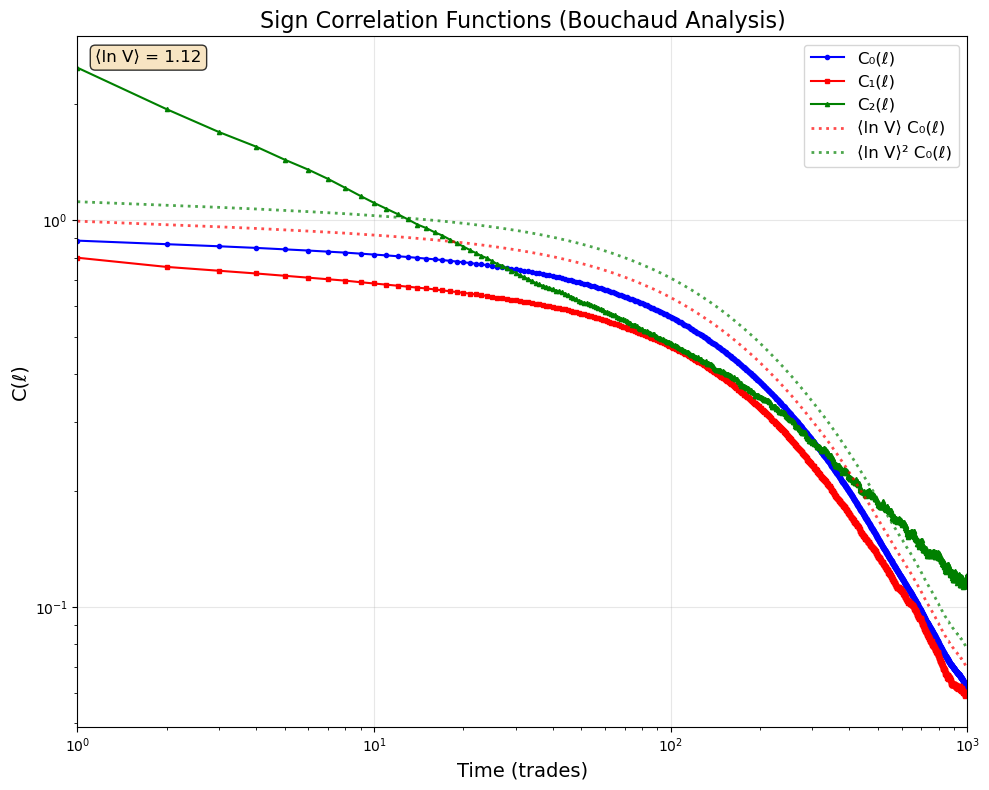

In [16]:
# Simple correlation functions plot
fig, ax = plt.subplots(figsize=(10, 8))

lags = correlations['lags']
C0 = correlations['C0'] 
C1 = correlations['C1']
C2 = correlations['C2']
mean_log_vol = correlations['mean_log_vol']

ax.loglog(lags, C0, 'o-', label='C₀(ℓ)', color='blue', markersize=3, linewidth=1.5)
ax.loglog(lags, np.abs(C1), 's-', label='C₁(ℓ)', color='red', markersize=3, linewidth=1.5)  
ax.loglog(lags, C2, '^-', label='C₂(ℓ)', color='green', markersize=3, linewidth=1.5)

theoretical_C1 = mean_log_vol * C0
theoretical_C2 = mean_log_vol**2 * C0

valid_mask = C0 > 0
ax.loglog(lags[valid_mask], np.abs(theoretical_C1[valid_mask]), ':', 
         color='red', alpha=0.7, linewidth=2, label='⟨ln V⟩ C₀(ℓ)')
ax.loglog(lags[valid_mask], theoretical_C2[valid_mask], ':', 
         color='green', alpha=0.7, linewidth=2, label='⟨ln V⟩² C₀(ℓ)')

# Labels and formatting
ax.set_xlabel('Time (trades)', fontsize=14)
ax.set_ylabel('C(ℓ)', fontsize=14) 
ax.set_title('Sign Correlation Functions (Bouchaud Analysis)', fontsize=16)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)
ax.set_xlim(1, max(lags))

textstr = f'⟨ln V⟩ = {mean_log_vol:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## 2. Propagator Model
- Propagator Model: P(t) = ∑G(t-s)ε(s)
- Temporal impact analysis (temporary vs permanent)
- Trade information content effects

In [ ]:
gamma = 0.24      # Sign correlation decay exponent
C0 = 0.20         # Correlation amplitude  
Gamma0 = 2.8e-3   # Overall scaling (Euros)
l0 = 20           # Short-time cutoff (trades)

# Critical exponent for diffusive prices
beta_c = (1 - gamma) / 2
print(f"Critical exponent βc = {beta_c:.3f}")


Critical exponent βc = 0.380


In [17]:
# P(t) = Σ G₀(t-s) ε(s) ln(V(s))
def propagator(t, t0=20, beta=0.4, Gamma0=0.001):
    """G₀(t) = Γ₀ * t₀^β / (t₀ + t)^β"""
    return Gamma0 * (t0**beta) / ((t0 + t)**beta)

# Theoretical response function
def theo_response(lags, C0, gamma, t0=20, beta=0.4, Gamma0=0.001):
    """R(ℓ) using Eq. 17 from the paper"""
    R_theory = []
    
    for lag in lags:
        # Direct term
        term1 = propagator(lag, t0, beta, Gamma0)
        
        # Correlation terms
        term2 = 0
        for n in range(1, min(lag, 100)):
            if n < len(correlations):
                corr = C0 / (n**gamma) if n > 0 else C0
                term2 += propagator(lag - n, t0, beta, Gamma0) * corr
        
        R_theory.append(term1 + term2)
    
    return np.array(R_theory)

def fit_propagator(params):
    t0, beta, Gamma0 = params
    if beta <= 0 or beta >= 1 or t0 <= 0 or Gamma0 <= 0:
        return 1e6
    
    R_pred = theo_response(lags[:len(response_func)], C0, gamma, t0, beta, Gamma0)
    return np.sum((response_func - R_pred)**2)

In [12]:
def response_function(max_lag=1000, beta=None):
    """
    R(l) = <ln V> * [G0(l) + ∑(n=1 to l-1) G0(l-n)*C1(n)]
    """
    if beta is None:
        beta = beta_c
        
    lags = np.arange(1, max_lag + 1)
    ln_V = 1.0
    
    R = np.zeros(len(lags))
    
    print(f"Calculating R(l) for β = {beta:.3f}...")
    
    for i, l in enumerate(lags):
        # Direct impact term
        R[i] = bare_propagator(l, beta)
        
        # Correlation-mediated impact
        for n in range(1, l):
            R[i] += bare_propagator(l-n, beta) * sign_correlation(n)
            
        R[i] *= ln_V
        
        if l % 200 == 0:
            print(f"  Computed up to lag {l}")
            
    return lags, R

lags, R_critical = response_function(max_lag=1000, beta=beta_c)


Calculating R(l) for β = 0.380...
  Computed up to lag 200
  Computed up to lag 400
  Computed up to lag 600
  Computed up to lag 800
  Computed up to lag 1000


In [13]:

beta_values = [0.38, 0.40, 0.42, 0.44]  # Around βc
colors = ['red', 'blue', 'green', 'orange']

# Calculate for different beta values
responses = {}
for beta in beta_values:
    print(f"β = {beta}:")
    lags, R = calculate_response_function(max_lag=1000, beta=beta)
    responses[beta] = R


β = 0.38:


NameError: name 'calculate_response_function' is not defined

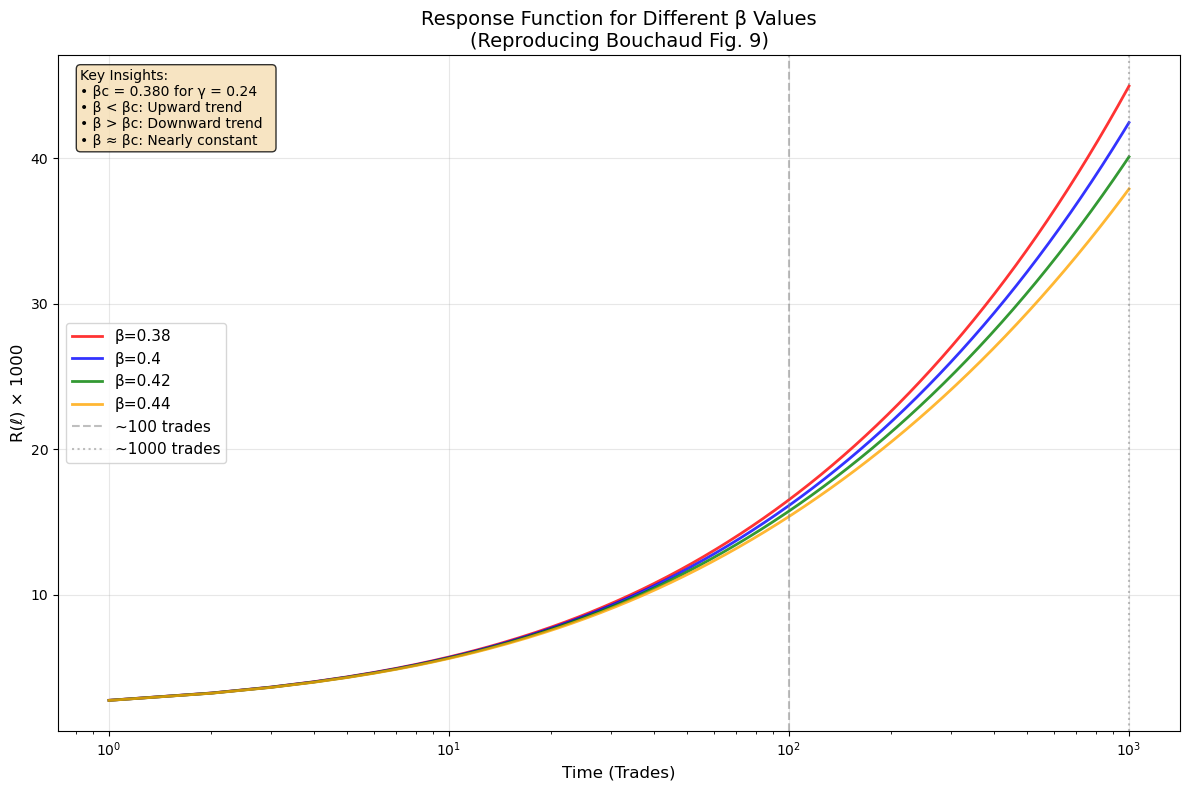

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Plot response functions for different beta values
for beta, color in zip(beta_values, colors):
    R = responses[beta]
    ax1.plot(lags, R * 1000, label=f'β={beta}', color=color, alpha=0.8, linewidth=2)

ax1.axvline(x=100, color='gray', linestyle='--', alpha=0.5, label='~100 trades')
ax1.axvline(x=1000, color='gray', linestyle=':', alpha=0.5, label='~1000 trades')

ax1.set_xlabel('Time (Trades)', fontsize=12)
ax1.set_ylabel('R(ℓ) × 1000', fontsize=12)
ax1.set_title('Response Function for Different β Values\n(Reproducing Bouchaud Fig. 9)', fontsize=14)
ax1.set_xscale('log')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

textstr = f'''Key Insights:
• βc = {beta_c:.3f} for γ = {gamma}
• β < βc: Upward trend
• β > βc: Downward trend  
• β ≈ βc: Nearly constant'''

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

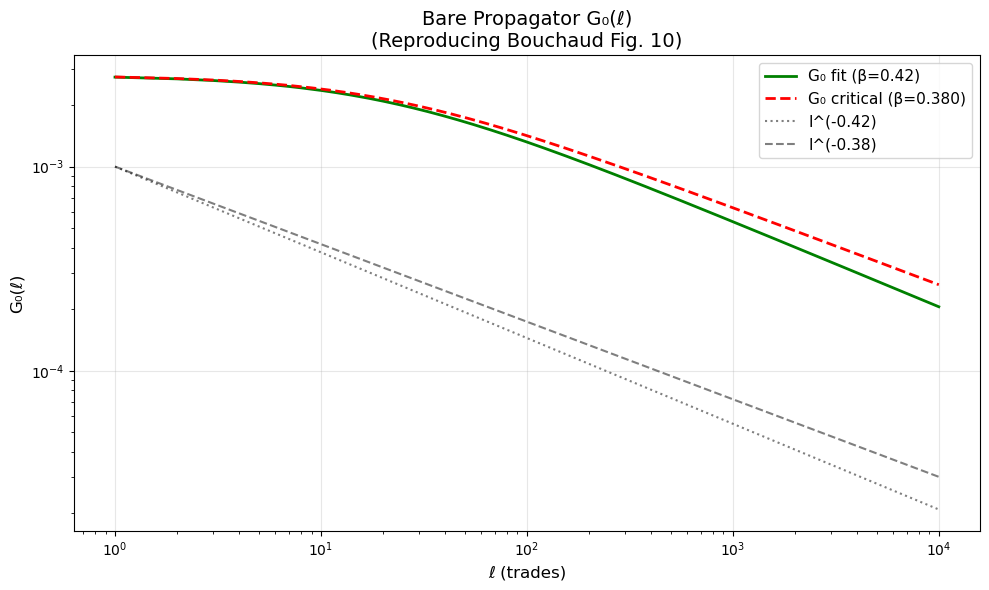

In [ ]:
fig, ax2 = plt.subplots(1, 1, figsize=(10, 6))

# Calculate propagator for extended range
lags_extended = np.arange(1, 10000)
G0_fit = np.array([bare_propagator(l, 0.42) for l in lags_extended])
G0_critical = np.array([bare_propagator(l, beta_c) for l in lags_extended])

# Plot on log-log scale
ax2.loglog(lags_extended, G0_fit, label='G₀ fit (β=0.42)', color='green', linewidth=2)
ax2.loglog(lags_extended, G0_critical, label=f'G₀ critical (β={beta_c:.3f})', 
           color='red', linestyle='--', linewidth=2)

# Add power-law reference lines
ax2.loglog(lags_extended, 1e-3 * lags_extended**(-0.42), 'k:', alpha=0.5, 
           label='l^(-0.42)')
ax2.loglog(lags_extended, 1e-3 * lags_extended**(-beta_c), 'k--', alpha=0.5, 
           label=f'l^(-{beta_c:.2f})')

ax2.set_xlabel('ℓ (trades)', fontsize=12)
ax2.set_ylabel('G₀(ℓ)', fontsize=12)
ax2.set_title('Bare Propagator G₀(ℓ)\n(Reproducing Bouchaud Fig. 10)', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print(f"\nModel Parameters:")
print(f"• Sign correlation decay: γ = {gamma}")
print(f"• Correlation amplitude: C₀ = {C0}")
print(f"• Overall scaling: Γ₀ = {Gamma0}")
print(f"• Short-time cutoff: ℓ₀ = {l0}")

print(f"• Critical exponent: βc = (1-γ)/2 = {beta_c:.3f}")
print(f"• Critical condition: 2β + γ = {2*beta_c + gamma:.1f}")

print(f"• For β = {beta_c:.3f} (critical): R(ℓ) nearly constant")
print(f"• For β = 0.42 (best fit): R(ℓ) shows realistic max/decay")

print(f"\nPhysical Interpretation:")
print(f"• Market at critical point balancing:")
print(f"  - Long-range correlations (super-diffusion)")
print(f"  - Impact decay (sub-diffusion)")
print(f"• Result: Diffusive (random walk) price process")

R_max_idx = np.argmax(responses[0.42])
R_max_lag = lags[R_max_idx]
R_max_value = responses[0.42][R_max_idx]

print(f"• Maximum response at ℓ ≈ {R_max_lag} trades")
print(f"• Maximum value: R_max = {R_max_value*1000:.3f} × 10⁻³")
print(f"• Ratio R_max/R(1) = {R_max_value/responses[0.42][0]:.2f}")


Model Parameters:
• Sign correlation decay: γ = 0.24
• Correlation amplitude: C₀ = 0.2
• Overall scaling: Γ₀ = 0.0028
• Short-time cutoff: ℓ₀ = 20
• Critical exponent: βc = (1-γ)/2 = 0.380
• Critical condition: 2β + γ = 1.0
• For β = 0.380 (critical): R(ℓ) nearly constant
• For β = 0.42 (best fit): R(ℓ) shows realistic max/decay

Physical Interpretation:
• Market at critical point balancing:
  - Long-range correlations (super-diffusion)
  - Impact decay (sub-diffusion)
• Result: Diffusive (random walk) price process
• Maximum response at ℓ ≈ 1000 trades
• Maximum value: R_max = 40.116 × 10⁻³
• Ratio R_max/R(1) = 14.62


## 3. ML Implementation
- Features: Volatility metrics, volume patterns, spreads, order book imbalance, decay patterns from propagator analysis
- Target: Direct price impact ΔP prediction
- Models: Compare ML predictions vs Square-root law vs Propagator model

In [ ]:
def features(trades_df):

    features = pd.DataFrame()
    
    features['log_volume'] = trades_df['log_volume']
    features['sqrt_volume'] = trades_df['sqrt_volume']
    features['trade_sign'] = trades_df['trade_sign']
    
    features['volatility_5'] = trades_df['price'].rolling(5).std()
    features['volatility_20'] = trades_df['price'].rolling(20).std()
    
    features['volume_ma_5'] = trades_df['volume_normalized'].rolling(5).mean()
    features['volume_ma_20'] = trades_df['volume_normalized'].rolling(20).mean()
    features['volume_ratio'] = features['volume_ma_5'] / features['volume_ma_20']
    
    # Propagator-derived features (assume G0 values computed)
    if 'G0_1' in trades_df.columns:
        features['G0_1'] = trades_df['G0_1']
        features['G0_10'] = trades_df['G0_10'] 
        features['G0_100'] = trades_df['G0_100']
    
    # Sign correlation features (C1, C2)
    features['sign_autocorr_1'] = trades_df['trade_sign'].rolling(10).apply(
        lambda x: x.autocorr(lag=1) if len(x) > 1 else 0
    )
    
    # Order imbalance proxy
    features['cumulative_signed_volume'] = (
        trades_df['trade_sign'] * trades_df['volume_normalized']
    ).rolling(20).sum()
    
    return features.fillna(0)

KeyError: 'spread'

## 4. Regime-Dependent Analysis
- Identify market conditions where traditional models underperform
- Cross-validation framework across different market regimes
- Performance comparison metrics focusing on model failure cases